In [66]:
import pandas as pd
import requests
import ast
import numpy as np
import time
import matplotlib.pyplot as plt
%matplotlib inline

More info on requests library can be found [here](http://docs.python-requests.org/en/master/user/quickstart/)

# Simple example

In [ ]:
curl -i -X POST https://data.austintexas.gov/resource/x9yh-78fz.json

curl --header "X-App-Token:HLR3sDnaPUVVakzmZzKPpFMkJ" --data { '$limit': 1, '$order': ':id', '$offset': 0,} https://data.austintexas.gov/resource/x9yh-78fz.json

In [61]:
# set endpoint URL
url = 'https://data.austintexas.gov/resource/x9yh-78fz.json'
# query params
payload = {'fiscal_year_issued': '2018'
           'contractor_zip': '78749',
           '$select': 'condominium, total_job_valuation,\
               longitude, latitude, permittype, total_new_add_sqft, \
               total_existing_bldg_sqft'}
# API token
headers = {'X-App-Token': 'HLR3sDnaPUVVakzmZzKPpFMkJ'} 

In [62]:
res = requests.get(url, params=payload, headers=headers)

In [63]:
print(res.status_code)
res.status_code == requests.codes.ok

200


True

In [64]:
# let's take a look at the header information
ast.literal_eval(res.headers['X-SODA2-Fields'])

['applicant_address1',
 'applicant_address2',
 'applicant_city',
 'applicant_full_name',
 'applicant_org',
 'applicant_phone',
 'applicant_phone_type',
 'applicantzip',
 'applieddate',
 'building_valuation',
 'building_valuation_remodel',
 'calendar_year_issued',
 'completed_date',
 'condominium',
 'contractor_address1',
 'contractor_address2',
 'contractor_city',
 'contractor_company_name',
 'contractor_full_name',
 'contractor_phone',
 'contractor_phone_type',
 'contractor_trade',
 'contractor_zip',
 'council_district',
 'day_issued',
 'description',
 'electrical_valuation',
 'electrical_valuation_remodel',
 'expiresdate',
 'fiscal_year_issued',
 'housing_units',
 'issue_date',
 'issue_method',
 'issued_in_last_30_days',
 'jurisdiction',
 'latitude',
 'legal_description',
 'link',
 'link_description',
 'location',
 'location_address',
 'location_city',
 'location_state',
 'location_zip',
 'longitude',
 'masterpermitnum',
 'mechanical_valuation',
 'mechanical_valuation_remodel',
 'med

In [15]:
def get_unique_keys(list_of_dicts):
    '''
    return unique keys from within a list of dicts
    '''
    json_keys = []
    for row in list_of_dicts:
        for k in row.keys():
            json_keys.append(k)
    return set(json_keys)

In [8]:
# create a template dictionary
# consisting of all unique keys
# within input dataset
df_dict = {}
for key in get_unique_keys(res.json()):
    df_dict[key] = []
    
# fill in the dictionary with
# values from the API call
# making sure to input nulls
# where needed
for row in res.json():
    for k in list(df_dict.keys()):
        try:
            df_dict[k].append(row[k])
            continue
        except KeyError:
            df_dict[k].append(np.nan)

In [9]:
# cram the dictionary into a dataframe
df = pd.DataFrame.from_dict(df_dict)

In [10]:
df.head(2)

,condominium,latitude,longitude,permittype,total_existing_bldg_sqft,total_job_valuation,total_new_add_sqft
0,NaN,30.22768623,-97.78692854,DS,NaN,NaN,NaN
1,No,30.16809048,-97.9131181,EP,NaN,NaN,1536


In [27]:
df.shape

(2000, 6)

# Let's page through the data

In [99]:
def page_api(n, api_key, page_size=1000):
    
    # set endpoint URL
    url = 'https://data.austintexas.gov/resource/x9yh-78fz.json'
    # query params
    payload = { '$limit': 1,
                '$order': ':id',
                '$offset': 0,
                '$select': 'permittype, applieddate'}
    # API token
    headers = { 'X-App-Token': api_key }
    
    # label encode permit string as ints
    permit_encoder = {'EP': 0, 'MP': 1, 'PP': 2, 'BP': 3, 'DS': 4}
    
    # perform initial call to get column header info
    res = requests.get(url, params=payload, headers=headers)
    
    # create a template dictionary
    # consisting of all unique keys
    # within input dataset
    df_dict = {}
    for key in get_unique_keys(res.json()):
        df_dict[key] = []

    # fill in the dictionary with
    # values from the API call
    # making sure to input nulls
    # where needed
    for row in res.json():
        for k in list(df_dict.keys()):
            try:
                df_dict[k].append(row[k])
                continue
            except KeyError:
                df_dict[k].append(np.nan)
    
    df = pd.DataFrame.from_dict(df_dict)
    
    for offset, limit in get_page_indexes(n, page_size):
        payload['$offset'] = offset
        payload['$limit'] = limit
        
        
        print('Starting ID {} page size {}...'.format(payload['$offset'], payload['$limit']))
        
        res = requests.get(url, params=payload, headers=headers)

        # zero out the data from the previous loop
        for k in df_dict.keys():
            df_dict[k] = []
        
        for row in res.json():
            for k in list(df_dict.keys()):
                try:
                    df_dict[k].append(row[k])
                    continue
                except KeyError:
                    df_dict[k].append(np.nan)
    
        # cram the dictionary into a dataframe
        df_paged = pd.DataFrame.from_dict(df_dict)

        df_paged['applieddate'] = pd.to_datetime(df_paged.copy()['applieddate'], format='%Y-%m-%d', errors='coerce')
        
        df_paged['permittype'] = df_paged.copy()['permittype'].apply(lambda x: permit_encoder[x] if x else 999)

#         for i in ['latitude', 'longitude']:
#             df_paged[i] = df_paged.copy()[i].astype(float)
            
        df = pd.concat([df, df_paged], axis=0, ignore_index=True)
    
        # don't overload the server with calls
        time.sleep(2)
    print('Completed successfully')
    return df.iloc[1:]

    
def get_page_indexes(n, page_size=1000):
    '''
    returns offset, pagesize
    '''
    
    cur_row = 1
    page_size = page_size
    first_loop_flag = 1
    
    page_indexes = []
    
    while cur_row < n:
        if first_loop_flag == 1:
            page_indexes.append([cur_row, page_size])
            cur_row += page_size
            first_loop_flag = 0
        else:
            if n < cur_row + page_size - 1:
                page_indexes.append([cur_row, n % page_size])
                cur_row += n % page_size
            else:
                page_indexes.append([cur_row, page_size - 1])
                cur_row += page_size
    
    return page_indexes

In [107]:
df = page_api(2000000, 'HLR3sDnaPUVVakzmZzKPpFMkJ', page_size=25000)

Starting ID 1 page size 25000...
Starting ID 25001 page size 24999...
Starting ID 50001 page size 24999...
Starting ID 75001 page size 24999...
Starting ID 100001 page size 24999...
Starting ID 125001 page size 24999...
Starting ID 150001 page size 24999...
Starting ID 175001 page size 24999...
Starting ID 200001 page size 24999...
Starting ID 225001 page size 24999...
Starting ID 250001 page size 24999...
Starting ID 275001 page size 24999...
Starting ID 300001 page size 24999...
Starting ID 325001 page size 24999...
Starting ID 350001 page size 24999...
Starting ID 375001 page size 24999...
Starting ID 400001 page size 24999...
Starting ID 425001 page size 24999...
Starting ID 450001 page size 24999...
Starting ID 475001 page size 24999...
Starting ID 500001 page size 24999...
Starting ID 525001 page size 24999...
Starting ID 550001 page size 24999...
Starting ID 575001 page size 24999...
Starting ID 600001 page size 24999...
Starting ID 625001 page size 24999...
Starting ID 650001 p

In [108]:
df['year'] = df.copy()['applieddate'].dt.year
df['month'] = df.copy()['applieddate'].dt.month

In [109]:
chart_df = df.groupby(df['applieddate'].dt.year)[['applieddate']].count()

In [110]:
chart_df.index.rename('year', inplace=True)

In [111]:
chart_df.reset_index(inplace=True)

In [112]:
chart_df.head()

,year,applieddate
0,1921.0,5
1,1969.0,3
2,1970.0,8
3,1971.0,9
4,1976.0,3


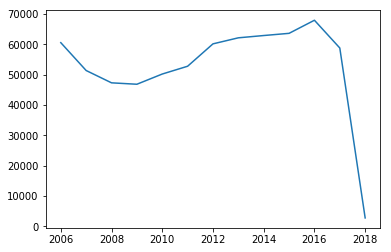

In [113]:
plt.plot(chart_df[ chart_df['year'] > 2005 ]['year'], chart_df[ chart_df['year'] > 2005]['applieddate'])